# Applied Machine Learning Days EPFL 2022 - Workshop on<br>**Visual Disinformation and the Dark Side of Internet Memes**<br> Part 1

##0. Basic Setup (fastai, datasets)

In [ ]:
# Set Data Path
import os

DATA_ROOT_PATH='/content/data'
os.environ["DATA_ROOT_PATH"] = DATA_ROOT_PATH

In [ ]:
!pip install fastai==2.5.2 --upgrade

In [ ]:
!mkdir -p {DATA_ROOT_PATH}
!wget https://www.dropbox.com/s/5jgx824bmw050yt/IWT_meme_data.tar.gz -P {DATA_ROOT_PATH}/

In [ ]:
!tar -xf {DATA_ROOT_PATH}/IWT_meme_data.tar.gz --directory {DATA_ROOT_PATH}/

## 1. Import of Python modules (must be executed!)

In [ ]:
import os
import re
import random
import json
from tqdm import tqdm
import numpy as np

import fastai
from fastai.vision.all import *
from fastai.text.all import *

import torch

from sklearn.preprocessing import minmax_scale

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Definition of Jupyter widgets & helper functions (must be executed!)

In [ ]:
# define widget to select train, valid or test set
style = {'description_width': 'initial'}
dataset_label = widgets.Dropdown(
    options=[('train', 'train'), ('valid', 'valid'), ('test', 'test')],
    value='train',
    step=1,
    description='Dataset:',
    style=style)

In [ ]:
# define widget to select one out of different preprocessing methods
style = {'description_width': 'initial'}
tmfs = [
        Resize(size=(112,112), method=ResizeMethod.Crop),
        Resize(size=(112,112), method=ResizeMethod.Squish)
        ]
preprocessing = widgets.Dropdown(
    options=[('Resize (crop)', tmfs[0]), ('Resize (squash)', tmfs[1])],
    value=tmfs[0],
    step=1,
    description='Image preprocessing:',
    style=style)

In [ ]:
# define widget to select one out of different cnn vision models
style = {'description_width': 'initial'}
cnn_models = widgets.Dropdown(
    options=[
             ('vgg16_bn', vgg16_bn),
             ('resnet18', resnet18),
             ('resnet34', resnet34),
             ('densenet121', densenet121)
             ],
    value=resnet34,
    step=1,
    description='CNN architecture:',
    style=style)

In [ ]:
# define widget to select one out of two different class labels
style = {'description_width': 'initial'}
class_label = widgets.Dropdown(
    options=[('meme', 0), ('not_meme', 1)],
    value=0,
    step=1,
    description='Class label:',
    style=style)

In [ ]:
def read_random_img_subset(path: Str, n_samples: Int, binary_labels: List[str]) -> List[PILImage]:
  '''
  Parameter:
    path: path to folder containing train, valid, test folders
    n_samples: number of randomly chosen samples
    binary_labels: list including two strings for binary class labels
  Returns:
    a list including n_samples of positive and negative example images each
  '''

  image_paths = {binary_labels[0]: [], binary_labels[1]: []}
  for dirpath, dirnames, files in os.walk(path):
    class_label = dirpath.split('/')[-1]
    for filename in files:
      image_paths[class_label].append(dirpath+'/'+filename)

  positive_samples = random.sample(image_paths[binary_labels[0]], n_samples)
  negative_samples = random.sample(image_paths[binary_labels[1]], n_samples)    

  random_img_subset = list(zip(positive_samples,positive_samples)) + list(zip(negative_samples,negative_samples))

  return random_img_subset

In [ ]:
def show_selected_image(path):
  fig, ax = plt.subplots(figsize=(6, 6))
  ax.imshow(plt.imread(path))
  ax.set_axis_off()
  ax.tick_params(axis='both', which='both', length=0)
  plt.tight_layout()
  plt.show()
  return path

In [ ]:
def show_loss(img_data):
  return(img_data)

## 3. Introduction & Data Visualization

An internet meme denotes a cultural, behavioral or stylistic element, which is propagated over the internet. It is characterized by its viral spread and continuous user-driven modifications. Limor Shifman provides a useful definition of internet memes including three criteria [1]: "(a) a group of digital items sharing common characteristics of content, form, and/or stance, which (b) were created with awareness of each other, and (c) were circulated, imitated, and/or transformed via the Internet by many users". A particular type of internet meme are Image-With-Text (IWT) memes. They typically include an image with superimposed text. This includes traditional [image macro](https://en.wikipedia.org/wiki/Image_macro) memes (see Figure 1), screengrabs with annotations, and comical illustrations.


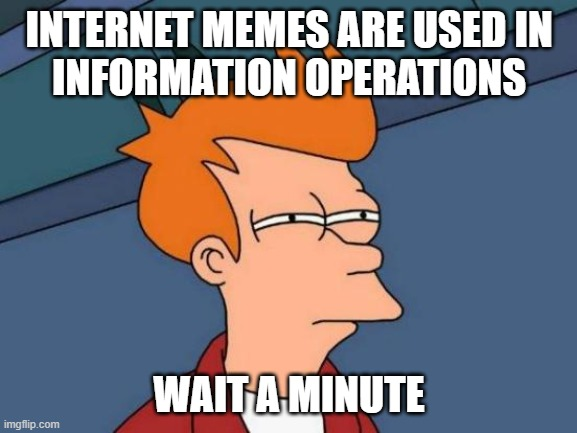

Figure 1. Example of an image macro meme. Textual information is superimposed on an image.

IWT memes are a powerful tool to influence online narratives. In particular, they are used on social media platforms to communicate ideas in a very concise fashion among different users. Therefore, it is not surprising that different actors, such as e.g. foreign intelligence services, terrorist organizations and private companies utilize IWT memes for malign purposes. In particular, visual disinformation is often propagated in form of an IWT meme (see e.g. [2]). They are typically part of a larger information operation, which may as well include other types of visual disinformation (miscontextualized images/videos, shallowfakes, deepfakes, and staged images/videos). A great awareness of internet culture and the political landscape of the target society is required in order to create successful IWT memes. Two examples that were used in actual information operations conducted by the Russian Main Intelligence Directorate (GRU) and Internet Research Agency (IRA) are shown in Figure 2. Information operations usually attempt to achieve short-term as well as long-term goals. The former typically correspond to influencing public opinion about a topic and/or election outcome. The latter includes the distortion of information space, the intent to paralyze decision-making, undermine public discourse and democratic institutions, and make people loose their understanding of what is true and false. Internet memes can effectively be used to achieve both short- and long-term goals of information operations. In the course of conducting information operations actors may employ content which polarizes the target group/society and can often be outright hateful. Internet memes tend to be very sticky and promote in-group vs. out-group dynamics (see e.g. this [case study](https://journals.sagepub.com/doi/full/10.1177/1461444819888746)). In contrast to textual content, images tend to generate stronger behavioral responses in the audience (e.g. decision [to donate money for a cause](https://onlinelibrary.wiley.com/doi/abs/10.1111/jcom.12184)). Therefore, IWT memes are an ideal vehicle to propagate hateful content and drive polarizing behavior.

There is no international legal basis that regulates so called hate speech. Its precise definition remains disputed. The United Nations define hate speech as follows [3]: "any kind of communication in speech, writing or behaviour, that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor." Hateful IWT memes are often propagated with the intent to generate intolerance and to incite hostility and violence.

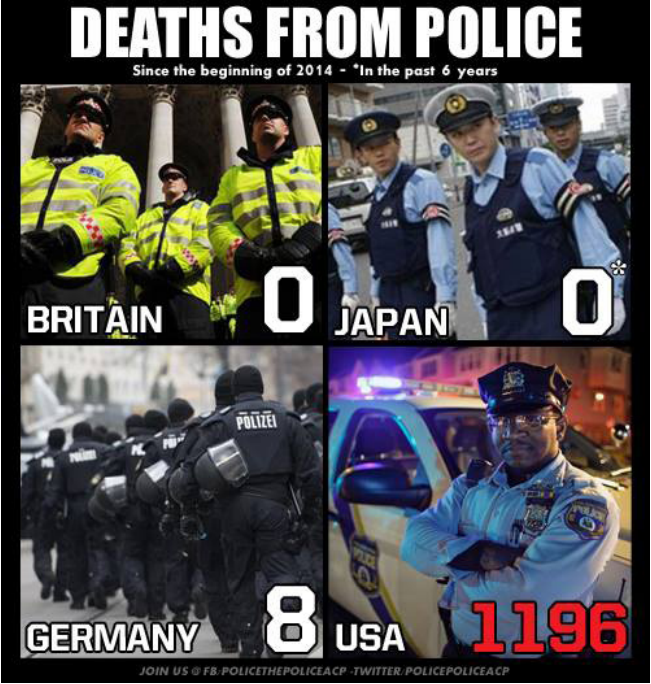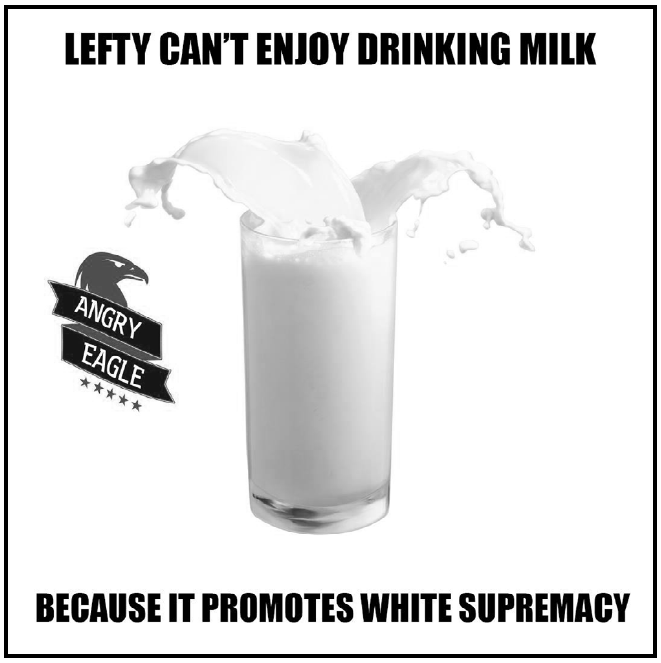

Figure 2. Two examples of IWT memes used in Russian information operations. Sources: Potemkin Pages & Personas: Assessing GRU Online Operations, 2014-2019; DiResta et al. 2018, The tactics and tropes of the Internet Research Agency.

As already mentioned, the majority of IWT memes are circulated on social media platforms, such as e.g. Twitter, Facebook and Reddit. A plethora of other image types is circulated as well on social media including holiday photos, natural images, street scenes, etc. Consequently, the first step in the analysis of IWT memes is their detection (i.e. differentiation from other images). This can be formulated as a binary classification problem including two classes: IWT memes (class 1) and non-IWT-meme images (class 0). Binary image classification problems can be effectively solved using Convolutional Neural Networks (CNNs). An exemplary CNN is shown in Figure 3. CNNs feature an architecture usually composed of multiple convolutional layers and can become very deep. Deep neural architecture suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). This problem is a consequence of gradient and backpropagation-based model training which leads to smaller and smaller gradient values the deeper we construct a neural network. More recent CNN architecture (e.g. ResNet, DenseNet) attempted to tackle the vanishing gradient problem. Note that CNNs for image classification usually require a **fixed input size** (e.g. 224x224x3 as shown in Figure 3).

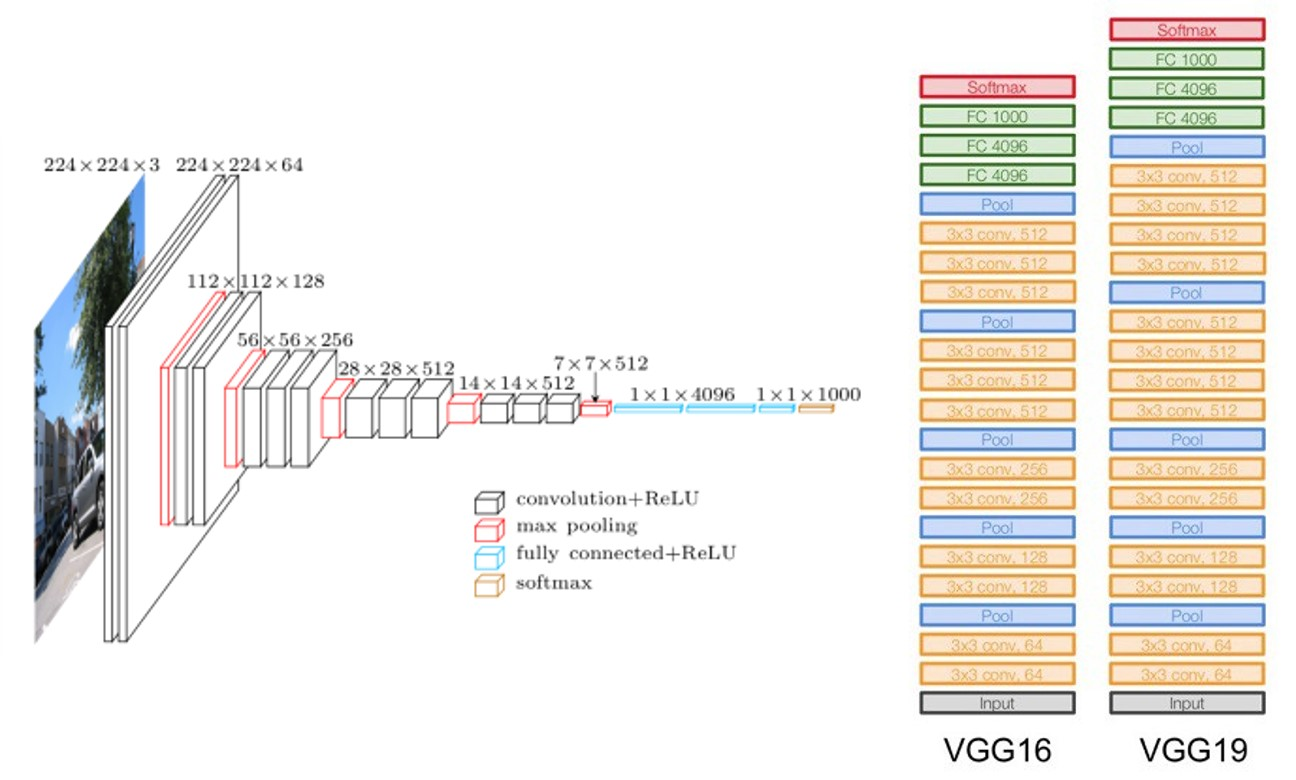

Figure 3. VGGNet architecture [4], which was the winning entry of the ImageNet competition in the year 2014.

The **objective** of this section is for every participant to fine-tune a pretrained CNN model on IWT meme / non-IWT-meme images. We will be looking at popular CNN architectures for image classification including VGGNet [4], ResNet [5], and DenseNet [6]. In addition, we will experiment with two different image preprocessing methods to highlight the impact of the preprocessing.

**Dataset:** In this section, we will be using IWT memes from last year's Facebook Hateful Memes Challenge: Hateful Memes Challenge and dataset (facebook.com). The dataset is split into training (8500 samples), validation (540 samples), and test set (2000 samples). For the purpose of this workshop, we will be working with the training and validation set only. Non-IWT-meme images were fetched randomly from the COCO-Text dataset (COCO-Text V2.0 (bgshih.github.io)), which is composed of any kind of image captured by a camera including text (e.g. a street scene with traffic sign). IWT memes and non-IWT-meme images are balanced. You will find the data in three different folders (train, valid, test), where each folder contains meme and not-meme subfolders. Figure 4 shows a representative IWT meme and non-IWT-meme image selected from the training dataset.

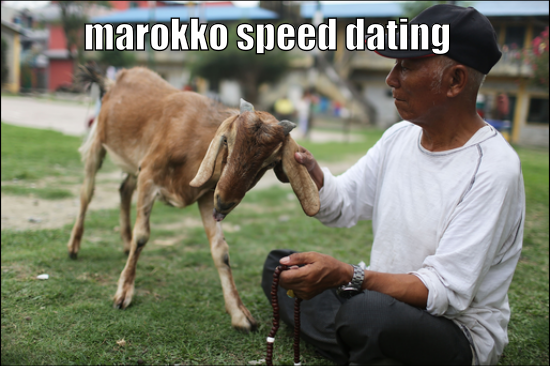

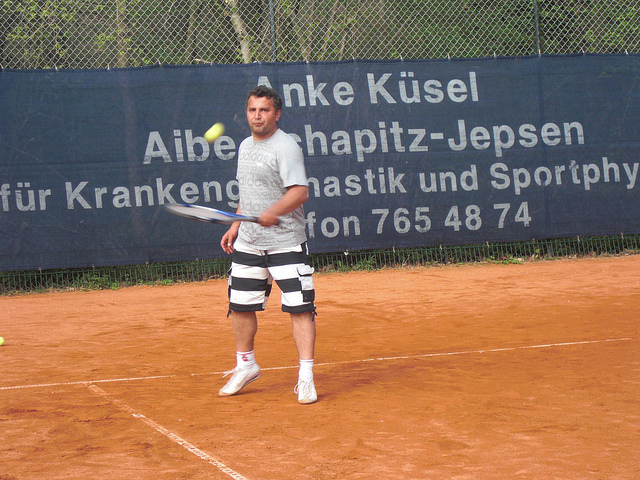

Figure 4. Example of an IWT meme (left) and a non-IWT-meme image (right) extracted from the challenge training data.

**References**
1. Shifman, Limor. Memes in Digital Culture. Cambridge, MA: The MIT Press, 2014.
2. Zannettou, Savvas, et al. WEAPONIZED INFORMATION OUTBREAK: A Case Study on COVID-19, Bioweapon Myths, and the Asian Conspiracy Meme. https://millercenter.rutgers.edu/wp-content/uploads/2020/10/NCRI-White-Paper-COVID-19-13-Apr-2020.pdf, [accessed 03.11.2021]
3. United Nations Strategy and Plan on Hate Speech. UN Strategy and Plan of Action on Hate Speech 18 June SYNOPSIS.pdf, [accessed 03.11.2021]
4. Simonyan, Karen, et al. Very Deep Convolutional Networks for Large-Scale Image Recognition. 1409.1556.pdf (arxiv.org), 2014.
5. Kaiming, He, et al. Deep Residual Learning for Image Recognition. https://arxiv.org/pdf/1512.03385.pdf, 2015.
6. Huang, Gao, et al. Densely Connected Convolutional Networks. https://arxiv.org/pdf/1608.06993.pdf, 2016.

### Task: Explore the Facebook Hateful Memes Challenge 2020 and COCO-Text datasets using the Jupyter widgets below.

In [ ]:
INPUT_PATH = os.path.join(DATA_ROOT_PATH, 'hateful_memes_classification_coco/')

In [ ]:
display(dataset_label)

In [ ]:
# this cell must be executed (!) if you change to different dataset using dropdown-menu above
path = os.path.join(INPUT_PATH, dataset_label.value)
random_img_subset = read_random_img_subset(path, 20, ['meme', 'not_meme'])

In [ ]:
clear_output()
interact(show_selected_image, path=random_img_subset)

**Question:** While inspecting the data above, do you think the negative examples (non-IWT-meme images) are representative of non-IWT-meme images we encounter in social media? Are there categories of images missing in the dataset?

In [ ]:
#@title Answer
# The COCO-Text dataset contains [scene text](https://en.wikipedia.org/wiki/Scene_text) images but also photographs without any text.
# While this certainly makes up a large portion of images shared on social media (holiday photos, indoor scenes, etc.),
# it does not include e.g. illustrations or screenshots.

## 4. IWT meme classification

### Task: Select a preprocessing method using the dropdown menus below (**application-oriented**)

In the following, study how the image preprocessing affects the classification performance of a Convolutional Neural Network (CNN) model. In particular, **compare the performance of resize (squash) versus resize (crop)**.

In [ ]:
# run to display dropdown menu
display(preprocessing)

Remark: Whenever you change the preprocessing method using the dropdown menu above, you have to re-run the following code cells (definition of DataBlock and DataBlock.dataloaders).

In [ ]:
mask_datablock = DataBlock(
  get_items=get_image_files,
  get_y=parent_label,
  blocks=(ImageBlock, CategoryBlock),
  item_tfms=preprocessing.value,
  splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
  batch_tfms=[Normalize.from_stats(*imagenet_stats)] # for this particular problem, we do not define any data augmentation
)

fast.ai implements the DataBlock API which enables us to easily load input (images), target variables (binary label), define preprocessing (=item_tfms) and data augmentation techniques (=batch_tfms). You will find a good intro to DataBlocks here: https://www.educative.io/edpresso/what-is-data-block-api-in-fastai. Official documentation is available here: https://docs.fast.ai/data.block.html.

In [ ]:
meme_dataloader = mask_datablock.dataloaders(
  INPUT_PATH, vocab=['meme', 'not_meme'],
  bs=256, num_workers=6, pin_memory=False)

Based on the previously defined DataBlock, we load the data contained in the meme and not_meme subfolders which define the binary targets.

In [ ]:
print('Number of samples in training set: '+str(len(meme_dataloader.train_ds)))
print('Number of samples in validation set: '+str(len(meme_dataloader.valid_ds)))

In [ ]:
meme_dataloader.show_batch(unique=False, figsize=(10,10))

### Task: Select a Convolutional Neural Network architecture using the dropdown menu below (**application-oriented**)

The dropdown menu below offers you a selection of different torchvision CNN models. They were all pretrained on the ImageNet classification dataset. We will fine-tune the selected model on meme vs not_meme data for a couple of epochs (transfer learning).

In [ ]:
# run to display dropdown menu
display(cnn_models)

In the following, we initialize our CNN model, define a number of metrics to evaluate binary classification performance, and log the results in 'meme_classifier_finetune.csv'. The command 'learn.summary()' will give you on overview on the architecture and the number of parameters of the CNN model.

In [ ]:
learn = cnn_learner(
    meme_dataloader,
    cnn_models.value,
    metrics=[accuracy, Precision(), Recall(),
             Recall(pos_label=0), FBeta(beta=1), RocAucBinary()],
    cbs=[CSVLogger(fname='meme_classifier_finetune.csv')]
    )

In [ ]:
learn.summary()

### Optional task: investigate other hyperparameters to improve model performance (**technical, open-ended**)

There are many more hyperparameters which could influence the performance of your neural network. The cnn_learner function above enables you to e.g. specify the loss function (loss_func), the optimizer (opt_func), weight decay (wd), etc. Official documentation is available here: https://docs.fast.ai/vision.learner.html#cnn_learner. Feel free to try out a different loss function (https://docs.fast.ai/losses.html) or optimizer (https://docs.fast.ai/optimizer.html#SGD-with-momentum).

### Optional task: run the learning rate finder (**technical, run this cell only once to save time**)

A crucial hyperparameter for CNNs and deep learning models in general is the so called [learning rate](https://en.wikipedia.org/wiki/Learning_rate). Training (and this includes fine-tuning) deep learning models involves usually a learning algorithm based on [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) optimization. The learning rate corresponds to the step size in gradient descent. Learning rates which are too large for the problem at hand can lead to divergence of the learning algorithm, while too small learning rates are time-consuming and can lead to overfitting. There are different learning rate schedules which vary the learning rate adaptively over time. Fastai employs the 1-cycle policy (cyclical learning rate schedule) which was proposed by Leslie N. Smith and Nicholay Topin in their paper [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). Cyclical learning rate cycle between a maximum learning rate and a base learning rate (base_lr). The main idea behind such a cycle is that larger learning rates enable the optimizer to escape from suboptimal local minima while smaller learning rates enable improved convergence. There is a lot of empirical evidence that cyclical learning rates provide solutions which are competitive with the optimal learning rate.

You will find the documentation on fast.ai's learning rate finder here: https://docs.fast.ai/callback.schedule.html#LRFinder. Different heuristics (e.g. valley) are available to suggest a good learning rate. Me personally, I tend to use 1/10 of the minimum, which can be derived from the minimum suggestion function.

In [ ]:
learn.lr_find(suggest_funcs = [minimum, valley])

### Task: Fine-tune your model on IWT meme dataset (**application-oriented**)

fast.ai's fine_tune function is a particular combination of two fine-tuning phases. In a first phase, all model weights are kept frozen except for the last layers (i.e. the fully-connected layers which provide the final output, also called 'head' of the network). The last layers are trained for a single epoch using a cyclical learning schedule with 1-cycle policy (https://fastai1.fast.ai/callbacks.one_cycle.html#Training-with-the-1cycle-policy). This step is important because the model was initially trained for multiclass classification with around 1000 classes from ImageNet and thus needs to be adapted for our current targets which are binary. In a second phase, all model weights are unfrozen and trained for the specified number of epochs using again cyclical learning with 1-cycle policy.

In [ ]:
learn.fine_tune(epochs=2, base_lr=1e-2)

While you are waiting for the CNN model to be fine tuned, let us recap the recipe we have just applied. It is a relatively generic recipe that works well for many image classification problems.:

1.   Choose preprocessing methods (and optionally also data augmentation)
2.   Choose a pretrained model (e.g. ResNet-34 trained on ImageNet data)
3.   Generate loss vs. lr rate plot (=learning rate finder). Max_lr = minimum in plot. Base_lr = max_lr/10. (optional)
4. Perform fine-tuning using cyclical learning rates with 1-cycle policy and learning rates estimated previously.
5. Evaluate fine-tuned model on validation data (and later on test data)

**Application-oriented info:** Very often images are repurposed to be the template for an internet meme. An interesting example of how recontextualized media content can turn into a meme is shown [here](https://mediamanipulation.org/case-studies/recontextualized-media-biden-voter-fraud-organization). While we are waiting for the model to be fine-tuned, it is worthwhile to think about how different types of media content can turn into internet memes. We are fine-tuning a model for the detection of IWT memes. However, there exist also internet memes without any textual component (e.g. a repurposed, popular frame of a video).

**Technical info:** The concepts of cyclical learning rates and the use of learning rate finders were popularized by researchers of the fast.ai community. It is worthwhile to take a look at this [blog article](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) by Sylvain Gugger which elaborates on those topics. In case you are working with keras, there is an implementation for the 1-cycle policy available here: [keras implementation](https://github.com/titu1994/keras-one-cycle).

In [ ]:
learn.show_results()

### Optional task: Visualize the first convolutional layer, judge the quality of filter kernels (**technical, run these cells only once to save time**)

In [ ]:
# adapted from https://www.kaggle.com/daisukelab/verifying-cnn-models-with-cam-and-etc-fast-ai
def visualize_first_conv_layer(learn):
    
    if cnn_models.label == 'vgg16_bn':
        conv1 = list(learn.model.children())[0][0][0]
    elif cnn_models.label == 'resnet18':
        conv1 = list(learn.model.children())[0][0]
    elif cnn_models.label == 'resnet34':
        conv1 = list(learn.model.children())[0][0]
    elif cnn_models.label == 'densenet121':
        conv1 = list(learn.model.children())[0][0][0]  
    weights = conv1.weight.data.cpu().numpy()
    weights_shape = weights.shape
    print(weights.ravel().shape)
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

It is always a good idea to visualize the first convolutional layer. If your convolutional kernels appear to have random weights (especially if pretrained), it might be a hint that your training/transfer learning failed. The kernels should largely correspond to different edge, corner and blob filters.

In [ ]:
visualize_first_conv_layer(learn)

### Task: inspect the performance of your model using the 'ClassificationInterpretation' class from fastai (**application-oriented**)

Now, let us inspect the performance of our current model in more detail. The implementation of the methods we will be using can be viewed here: https://github.com/fastai/fastai/blob/master/fastai/interpret.py#L51. We will generate a confusion matrix to obtain a first impression on false-positive and false-negative rates. In addition, we will also plot some misclassifications (using 'plot_top_losses()') and print classification metrics (using 'print_classification_report()')

In [ ]:
interpreter = ClassificationInterpretation.from_learner(learn)

In [ ]:
plt.rcParams.update({'font.size': 16})
interpreter.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
plt.rcParams.update({'font.size': 8})
interpreter.plot_top_losses(9, ncols=3, figsize=(8, 8))
#plt.tight_layout()

In [ ]:
interpreter.print_classification_report()

**Question 1:** When using 'resize(crop)' preprocessing, what do you observe with regards to the wrongly predicted cases above? What are potential factors relevant for misclassification?

**Question 2:** When using 'resize(squash)' preprocessing, what do you observe with regards to the wrongly predicted cases above? What are potential factors relevant for misclassification?

In [ ]:
#@title Answer
# Question 1: For a couple of IWT memes, the text content was cropped during the preprocessing making the image look like a regular photograph.
# Question 2: Most of the wrongly classified examples contain relatively small white font including sometimes poor contrast to the background image.
# Question1&2: We observe that an image being labeled as 'not_meme' from the COCO-Text dataset does have the appearance of classic image macro meme (Text: Don't worry... I'll take him to the hospital).

### Task: Probe generalization of our model and investigate image regions responsible for classification result (GradCAM) (**application-oriented**)

We will now have a closer look at some of the misclassified examples. In order to do so, we need a couple of more helper functions defined below (these cells must be executed!).

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
def compute_GradCAM(img, cls, learner):
  x, = first(meme_dataloader.test_dl([img]))
  with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
      output = learn.model.eval()(x.cuda())
      act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    softmax_probabilities = F.softmax(output[0]).cpu().detach().numpy()

  return x, cam_map, softmax_probabilities

In [ ]:
def show_GradCAM(img, cls, label, cam_map, softmax_probabilities):
  fig, ax = plt.subplots(figsize=(8, 8))
  img_dec = TensorImage(meme_dataloader.train.decode((img,))[0][0])
  plt.title(label +', softmax_prob: '+ str(softmax_probabilities[cls]))
  img_dec.show(ctx=ax)
  ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,112,112,0), interpolation='bilinear', cmap='magma')

In the following cell, we utilize the 'top_losses' function of the fastai interpreter (https://docs.fast.ai/interpret.html#Interpretation.top_losses) to obtain the 8 top losses and interactively visualize them using a widget.

In [ ]:
top_losses_indices = interpreter.top_losses(k=8)[1]
top_losses_imgs = [img[0] for img in meme_dataloader.valid_ds[top_losses_indices]]
top_losses = list(zip([str(idx.numpy()) for idx in top_losses_indices],top_losses_imgs))
img_path_widget = interact(show_loss, img_data=top_losses)

In [ ]:
# run to display dropdown menu
display(class_label)

In order to obtain an impression which parts of a test image are responsible for the classification result, we employ GradCAM. GradCAM is a gradient-based method to generate visual saliency maps. In contrast to CAM, GradCAM can generate saliency maps irrespective of the underlying neural network architecture. You will find a review of different methods to generate saliency maps [here](https://mrsalehi.medium.com/a-review-of-different-interpretation-methods-in-deep-learning-part-1-saliency-map-cam-grad-cam-3a34476bc24d).

In [ ]:
img = img_path_widget.widget.result
img_proc, cam_map, softmax_probabilities = compute_GradCAM(img, class_label.value, learn)

In [ ]:
show_GradCAM(
    img_proc, class_label.value,
    class_label.label, cam_map,
    softmax_probabilities)

From our previous experiments, it appears that CNNs can perform fairly well the distinction of IWT memes from scene text images.

**Question:** What are the likely causes for misclassification? Try to understand which image regions potentially misled the classifier. Are you convinced by the experiments we have just performed above?

In [ ]:
#@title Answer
# Answer: For some of the cases which were misclassified as not_meme,
# it seems that the font is simply to small or the contrast not good enough.
# In those cases, the text regions did not contribute much to the decision of the classifier.

Now, we bring in some new data from an actual Chinese information operation that happened last year on Twitter (2021) and was subsequently identified as such by Twitter itself (see corresponding [blog post](https://blog.twitter.com/en_us/topics/company/2021/disclosing-state-linked-information-operations-we-ve-removed) for more details). The information operation featured content directed towards shaping the narrative on the well-being of the [Uyghur population](https://en.wikipedia.org/wiki/Uyghur_genocide) in Xinjiang as well as topics related to the origin of COVID-19.
Apply the classifier to these new images and see how it performs and what the output of GradCAM looks like. Let us probe the generalization of the model.

**Question:** Do you think our model would be ready for deployment? Could there be images not contained in the training data which are similar to IWT memes and be misclassified as such?

In [ ]:
random_img_subset = read_random_img_subset(os.path.join(DATA_ROOT_PATH, 'test_cases/'), 3, ['meme', 'not_meme'])
img_path_widget = interact(show_selected_image, path=random_img_subset)

In [ ]:
img = PILImage.create(img_path_widget.widget.result)
img_proc, cam_map, softmax_probabilities = compute_GradCAM(img, class_label.value, learn)

In [ ]:
show_GradCAM(img_proc, class_label.value, class_label.label, cam_map, softmax_probabilities)

### Optional task: classification offensive versus non-offensive IWT memes (**application-oriented**)

In this optional task, we look at a different dataset: MultiOFF. It contains IWT memes featuring offensive and non-offensive content. The purpose of the dataset is to study binary classification of offensive and non-offensive IWT memes. Let us first explore a couple of images contained in the dataset.

In [ ]:
display(dataset_label)

In [ ]:
INPUT_PATH = os.path.join(DATA_ROOT_PATH, 'MultiOFF_classification/')

In [ ]:
path = os.path.join(INPUT_PATH, dataset_label.value)
random_img_subset = read_random_img_subset(path, 20, ['non-offensive', 'offensive'])

In [ ]:
interact(show_selected_image, path=random_img_subset)

**Question:** Study offensive and non-offensive image macro memes. Focus on the non-offensive images. What are your observations?

In [ ]:
#@title Answer
# Answer: In general, there are a number of IWT memes in the dataset which were classified as non-offensive by the authors but appear to be clearly offensive.
# It is not clear if this is an issue of interpretation or simply wrong annotations.

####Optional task: Solve classification task using image data only.

In [ ]:
# run to display dropdown menu
display(preprocessing)

In [ ]:
offensive_mask_datablock = DataBlock(
  get_items=get_image_files,
  get_y=parent_label,
  blocks=(ImageBlock, CategoryBlock), 
  item_tfms=preprocessing.value,
  splitter=GrandparentSplitter(train_name=('train','valid'), valid_name='test'),
  batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
offensive_meme_dataloader = offensive_mask_datablock.dataloaders(
    INPUT_PATH, bs=256, num_workers=6)
offensive_meme_dataloader.show_batch()

In [ ]:
# run to display dropdown menu
display(cnn_models)

In [ ]:
learn = cnn_learner(
    offensive_meme_dataloader, cnn_models.value,
    metrics=[accuracy, Precision(), Recall(),
    Recall(pos_label=0), FBeta(beta=1), RocAucBinary()])

In [ ]:
# we will not run the learning rate finder in this case to save some time
#learn.lr_find()

In [ ]:
learn.fine_tune(5, base_lr=1e-3)

**Question:** How would you judge the performance of the classifier? What is the likely cause for misclassifications? More importantly, do you think a binary classification of offensive and non-offensive content is a meaningful task to begin with?

In [ ]:
#@title Answer
# Answer: The performance of the classifier is fairly modest, which may be related to the potentially wrongly labeled cases identified previously.
# I think binary classification tasks of subjective categories (as e.g. offensiveness) should be discussed very carefully. It us up for debate whether such tasks are meaningful or not.

## 5. Optical Character Recognition (OCR) of IWT-meme and non-meme data and topic modeling

In this section, we will look at a task that can be performed after we have identified a particular image as IWT meme: optical character recognition (OCR). We will be using [easyocr](https://github.com/JaidedAI/EasyOCR) to try to translate the embedded text in our IWT meme data (and non-IWT-meme data) to actual strings which can be further investigated. OCR is by no means an easy task. Based on our initial experience using publicly-available OCR methods, we realized that most of those methods are optimized to perform OCR of text documents. This implies that they are optimized for OCR of black font on white background, which in most of the cases does not apply for IWT memes.

For this task, we simply try out easyocr on our data without applying any specific preprocessing. This way, we obtain a first impression on the performanc of easyocr. We start by installing easyocr and the required version of OpenCV. We import the required Python modules: easyocr for OCR processing, nltk for natural language processing and wordcloud to generate wordcloud figures.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install easyocr

In [ ]:
import easyocr
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')

In [ ]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

The following cells depend on the data loaded using the 'meme_dataloader' object defined at the beginning of the IWT meme classification exercises. **Make sure that you have run those cells before you proceed**.

We start by retrieving all data contained in our dataloader which is labelled as 'meme' since we have groundtruth text data for the IWT memes of the Facebook Hateful Memes dataset available.

In [ ]:
ordered_meme_ids = []
for i, data in enumerate(tqdm(meme_dataloader.valid_ds.items)):
  if str(data).split('/')[-2] == 'meme':
    ordered_meme_ids.append(str(data).split('/')[-1].split('.')[0])

In [ ]:
# read groundtruth data
INPUT_PATH = os.path.join(DATA_ROOT_PATH, 'hateful_memes_classification_coco/')
with open(INPUT_PATH+'valid.jsonl') as f:
    groundtruth_text_data = [json.loads(line) for line in f]

We initialize an easyocr reader object to translate embedded English text. For achieving this, we choose the most recent text recognition model for English text which is 'english_g2'. The necessary model files will be downloaded automatically. More information on the different available parameters can be found in the [EasyOCR documentation](https://www.jaided.ai/easyocr/documentation/).

In [ ]:
reader = easyocr.Reader(['en'], gpu=True, recog_network='english_g2')

We perform OCR on IWT meme and not-meme images using the previously initialized easyocr reader.

In [ ]:
# perform ocr on IWT meme and not-meme images using easyocr reader
meme_tokens = []
not_meme_tokens = []
for i, data in enumerate(tqdm(meme_dataloader.valid_ds)):
  x = data[0]
  y = data[1]
  result = reader.readtext(np.array(x.convert('L')), decoder='wordbeamsearch', beamWidth=5)
  tokens = ' '.join([token[1].lower() for token in result])

  if y == 0:
    meme_tokens.append(tokens)
  else:
    not_meme_tokens.append(tokens)

In [ ]:
print(meme_tokens)

In [ ]:
ocr_estimates = list(zip(ordered_meme_ids,meme_tokens))

We take a random subsample (10 samples) of OCR estimates generated previously by easyocr.

In [ ]:
subsample_ocr_estimates = random.sample(ocr_estimates, 10)

Subsequently, we fetch the corresponding ground truth data for the previosuly samples OCR estimates.

In [ ]:
subsample_groundtruth = []
for sample in subsample_ocr_estimates:
  gt_entry = next(item for item in groundtruth_text_data if item["id"] == sample[0])
  subsample_groundtruth.append(gt_entry)

In [ ]:
# helper function to visualize meme with corresponding ocr estimate and groundtruth
def show_ocr_estimate(ocr_estimate_idx):
  clear_output()
  img_path = [str(path) for path in meme_dataloader.valid_ds.items if str(path).split('/')[-1].split('.')[0] in ocr_estimate_idx]
  plt.imshow(plt.imread(img_path[0]))
  estimate_text = [data[1] for data in subsample_ocr_estimates if data[0] == ocr_estimate_idx]
  print('Estimate of easyocr: '+estimate_text[0])
  gt_text = [data['text'] for data in groundtruth_text_data if data['id'] == ocr_estimate_idx]
  print('Groundtruth string: '+gt_text[0])
  plt.show()


In [ ]:
subsample_ocr_estimates_unzipped = list(zip(*subsample_ocr_estimates))
img_path_widget = interact(show_ocr_estimate, ocr_estimate_idx=list(subsample_ocr_estimates_unzipped[0]))

Now, we are combining all extracted tokens from IWT memes and non-IWT-meme images to generate wordcloud representations of the most frequently occuring words.

In [ ]:
complete_meme_texts = ' '.join(meme_tokens)

In [ ]:
complete_meme_texts

In [ ]:
wordcloud = WordCloud(width = 500, height = 250, random_state=1, max_words=30, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords.words('english')).generate(complete_meme_texts)
plot_cloud(wordcloud)

In [ ]:
complete_not_meme_texts = ' '.join(not_meme_tokens)

In [ ]:
wordcloud = WordCloud(width = 500, height = 250, random_state=1, max_words=30, background_color='black', colormap='Set2', collocations=False, stopwords = stopwords.words('english')).generate(complete_not_meme_texts)
plot_cloud(wordcloud)

Wordcloud visualizations can provide us with a first impression on the potential topics contained in the extracted texts of the datasets. **Question:** What topics may be contained in the extracted text of IWT meme and non-IWT-meme images?

In [ ]:
#@title Answer
# Answer: Based on the most frequent words in the wordcloud for IWT meme images, we can argue that topics surrounding race (black/white), gender (dishwasher=sexist slur for women), and religion (islam) are most prevalent.
# For the non-IWT-meme images, we can hypothesize that images with street scenes (stop) from the USA (chase) are most prevalent. However, many of the extracted strings appear to be not meaningful.

### Task: Discover topics of previously extracted IWT meme text

In this final task, we use the previously extracted text tokens from IWT memes and try to explore latent topics in the data in an unsupervised fashion. In a first step, we perform a latent semantic analysis (LSA). In order to do so, we first construct a document(=meme)-term matrix using sklearn's CountVectorizer. LSA then relies on a Singular Value Decomposition (SVD) of that matrix. The singular vectors contained in V_t correspond to potential topics in the dataset. In a second step, we will use the Biterm Topic Model (BTM) which is looking for word-word co-occurences to uncover topics in the dataset. It has been shown to perform well for short texts and IWT memes. 

In [ ]:
# https://github.com/markoarnauto/biterm
!pip install biterm

In [ ]:
from scipy import linalg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from biterm.utility import vec_to_biterms, topic_summuary
from biterm.btm import oBTM

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

We use sklearn's CountVectorizer to generate a meme-term matrix with minimum (2 occurences) and maximum thresholds (occuring in >95% of all memes) for terms occuring in the extracted text of IWT meme images. Furthermore, we only take the top-100 most frequently occuring terms into consideration for the LSA (via parameter max_features) and remove English stop words. The helper function defined in the previous cell (preprocess_text) will be used to guarantee that all text is lowercase and that decimal numbers are removed from the strings.

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words=stopwords.words('english'), preprocessor=preprocess_text)
vectors = vectorizer.fit_transform(meme_tokens).toarray()
vectors.shape

In [ ]:
vocabulary = np.array(vectorizer.get_feature_names_out())

In [ ]:
U, S, V_t = linalg.svd(vectors, full_matrices=False)

In [ ]:
plt.plot(S)

In [ ]:
num_top_words=10

def show_topics(a):
    top_words = lambda t: [vocabulary[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

Let us print the first 10 vectors which may correspond to potential topics.

In [ ]:
show_topics(V_t[:10])

Now, we move on the Biterm Topic Model. For this model, the number of expected topics can be pre-defined (parameter num_topics).

**Question**: The IWT meme data of the Facebook Hateful Memes dataset contains memes which were labelled as either hateful or not hateful (binary label). Let us explore, if we can capture them as topics (hateful/not-hateful) using the Biterm Topic Model below by setting num_topics=2. How would you judge the result?

In [ ]:
biterms = vec_to_biterms(vectors)

In [ ]:
btm = oBTM(num_topics=2, alpha=50/20, beta=0.005, V=vocabulary)
topics = btm.fit_transform(biterms, iterations=1000)

In [ ]:
topic_summuary(btm.phi_wz.T, vectors, vocabulary, 20)